In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import re
import html
import ast
import contractions

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GRU, SpatialDropout1D, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
with open('/content/drive/MyDrive/Sentiment_analysis/data.pkl', 'rb') as f:
  data = pickle.load(f)

In [ ]:
df = data['data']
tokenizer = data['tokenizer']
embedding_matrix = data['embedding_matrix']

In [ ]:
df = df[['sentiment', 'preprocess_review', 'sequences']]

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_length = 300 # Can change
df['padded_sequences'] = pad_sequences(df['sequences'], maxlen=max_sequence_length, padding='pre').tolist()

<ipython-input-8-d0f6bbd9a2e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['padded_sequences'] = pad_sequences(df['sequences'], maxlen=max_sequence_length, padding='pre').tolist()


In [ ]:
X = df['padded_sequences']
y = df['sentiment']

X_array = np.array(X.tolist(), dtype=np.int32)
y_array = np.array(y.tolist(), dtype=np.float32)

In [ ]:
from sklearn.model_selection import train_test_split

validation_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_array, y_array, test_size=validation_split, random_state=42)

In [ ]:
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [ ]:
import keras
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
model = Sequential()

embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_shape=(X_array.shape[1],),
                            trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Attention())
# model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 97ms/step - accuracy: 0.7892 - auc: 0.8694 - loss: 0.4298 - precision: 0.7884 - recall: 0.7830 - val_accuracy: 0.8899 - val_auc: 0.9614 - val_loss: 0.2534 - val_precision: 0.8861 - val_recall: 0.8968
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 95ms/step - accuracy: 0.8946 - auc: 0.9608 - loss: 0.2535 - precision: 0.8913 - recall: 0.8975 - val_accuracy: 0.8994 - val_auc: 0.9663 - val_loss: 0.2371 - val_precision: 0.8900 - val_recall: 0.9133
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 97ms/step - accuracy: 0.9147 - auc: 0.9713 - loss: 0.2164 - precision: 0.9142 - recall: 0.9135 - val_accuracy: 0.9055 - val_auc: 0.9690 - val_loss: 0.2263 - val_precision: 0.9026 - val_recall: 0.9107
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 90ms/step - accuracy: 0.9266 - auc: 0.9783 - loss: 0.1876 - precision: 0.9252 - recall: 0.9267 - val_accuracy: 0.9019 - val_auc: 0.9704 - val_loss: 0.2489 - val_precision: 0.8680 - val_recall: 0.9498
Epoch 5/50
625/625 ━━━━━

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(val_dataset)
y_pred = (y_pred > 0.5)
print(classification_report(y_val,y_pred))

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90      4961
         1.0       0.90      0.91      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



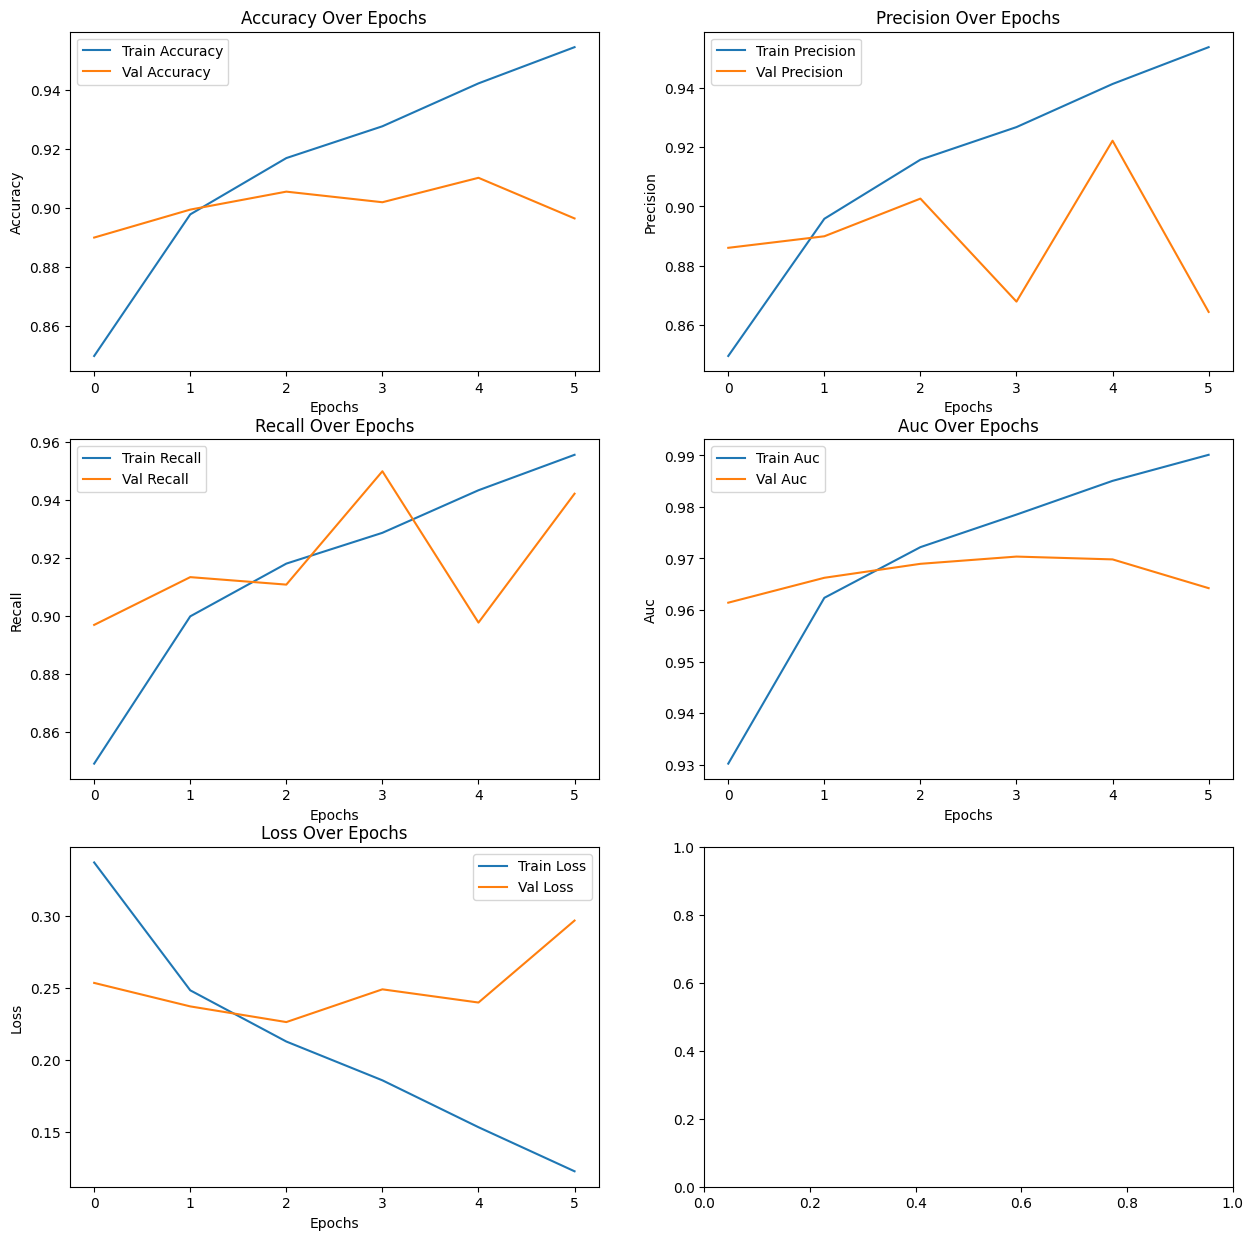

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics_grid(history):
    metrics = ['accuracy', 'precision', 'recall', 'auc', 'loss']
    validation_metrics = [f'val_{metric}' for metric in metrics]

    num_metrics = len(metrics)
    num_rows = 3
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i, metric in enumerate(metrics):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        ax.plot(history.history[metric], label=f'Train {metric.capitalize()}')
        ax.plot(history.history[validation_metrics[i]], label=f'Val {metric.capitalize()}')
        ax.set_title(f'{metric.capitalize()} Over Epochs')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.capitalize())
        ax.legend(loc='best')

    plt.show()

# Example usage
plot_metrics_grid(history)

In [ ]:
y_pred = model.predict(val_dataset)

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


<Axes: >

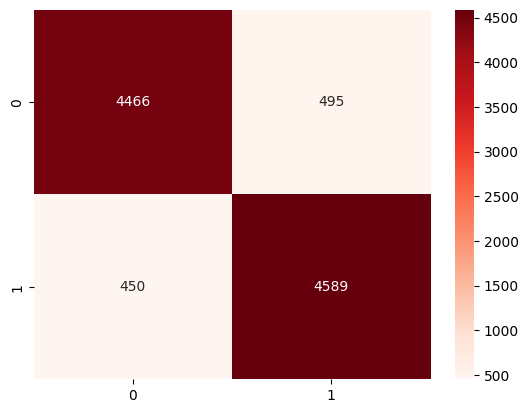

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(val_dataset)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')

In [ ]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = html.unescape(text)
    text =  re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'/', ' ', text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\bs\b', '', text)
    return ' '.join(text.split())

def normalize_stretched_word(word):
    return re.sub(r'(.)\1+', r'\1\1', word)

def lemmatize_and_normalize_text(text):
    tokens = word_tokenize(text.lower())
    normalized_tokens = [normalize_stretched_word(token) for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in normalized_tokens]
    return ' '.join(lemmatized_tokens)

def predict(text):
    text = preprocess(text)
    text = lemmatize_and_normalize_text(text)
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list], maxlen = 300, padding='pre')
    pred = model.predict(token_list)[0][0]

    return pred

In [ ]:
text = "The most beautiful 20 mins i spent in a long time!"
predict(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


0.93599844